In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import h5py

from matplotlib.gridspec import GridSpec

from numpy.polynomial.legendre import legval,legfit
import matplotlib as mpl
mpl.rcParams['font.size']=18
mpl.rcParams['font.serif'] = "Bitstream Vera Serif"
mpl.rcParams['font.family'] = "serif"

import os
import glob
from numpy import polyfit,polyval

In [2]:
def filter_with_legPoly(cpsi,cor,max_deg):
    deg = range(0,max_deg,2)
    cor_legfit = np.zeros_like(cor)
    for ii in range(cor.shape[0]):
        x=cpsi[ii]
        cc=legfit(x,cor[ii],deg)
        cor_legfit[ii] = legval(x,cc)
    return cor_legfit

def filter_with_legPoly2(cpsi,cor,max_deg):
    
    cor_legfit = np.zeros_like(cor)
    for ii in range(cor.shape[0]):
        deg = range(0,max_deg[ii],2)
        x=cpsi[ii]
        cc=legfit(x,cor[ii],deg)
        cor_legfit[ii] = legval(x,cc)
    return cor_legfit

def legPoly_and_remove_0th(cpsi,cor,max_deg):
    deg = range(0,max_deg,2)
    cor_legfit = np.zeros_like(cor)
    for ii in range(cor.shape[0]):
        x=cpsi[ii]
        cc=legfit(x,cor[ii],deg)
#         set the 0th order to 0
        cc[0] = 0
        cor_legfit[ii] = legval(x,cc)
    return cor_legfit

def symmetrize(diff):
    num_phi = diff.shape[-1]
    return 0.5*(diff[:,:num_phi/2]+diff[:,num_phi/2:])

In [197]:
num_phi = 326
phi_offset = 10
cutoff = 0
cutoff2= 36
cpsi = np.load('/reg/neh/home/qiaoshen/run16_notebooks/encodeZ400_cpsi.npy')[cutoff:cutoff2
                                                                                  ,phi_offset:num_phi/2-phi_offset]
qvalues = np.load('/reg/neh/home/qiaoshen/run16_notebooks/encodeZ400_qvalue.npy')[cutoff:cutoff2]

In [244]:
proteins=['ALF','GDP']
sample_cors =[]
sample_errs=[]
sample_cors_legfit =[]
diff_cors =[]
diff_cors_legfit=[]
diff_errs =[]
n_shots=[]
max_deg=30

for ss in proteins:
    f = h5py.File('/reg/d/psdm/cxi/cxilr6716/scratch/cali_gai_cor_results/%s_buf_chunks_split_maskDivide.h5'%ss,'r')
    
    buf = f['running_ave_cor'].value

    buf_err = f['running_ave_err'].value
#     print fe['chunk_err'].value[5,10].mean()
    sample_cors.append(buf[:,:,phi_offset:num_phi/2-phi_offset])
    sample_errs.append(buf_err[:,:,phi_offset:num_phi/2-phi_offset])

    
    f2 = h5py.File('/reg/d/psdm/cxi/cxilr6716/scratch/cali_gai_cor_results/%s_pro_chunks_split_maskDivide.h5'%ss,'r')
    pro = f2['running_ave_cor'].value
    pro_err = f2['running_ave_err'].value
    

    n_buf = f['running_num_shots'].value.astype(float)
    n_buf = n_buf.sum(1)[:,0]

        
    n_pro = f2['running_num_shots'].value.astype(float)
    n_pro = n_pro.sum(1)[:,0]
    n_shots.append( n_pro) 
    
    
    pro *= (n_pro/(n_pro+n_buf))[:,None,None]
    pro_err *=(n_pro/(n_pro+n_buf))[:,None,None]
#     
    buf *= (n_buf/(n_pro+n_buf))[:,None,None]
    buf_err *=(n_buf/(n_pro+n_buf))[:,None,None]


    sample_cors.append(pro[:,:,phi_offset:num_phi/2-phi_offset])
    sample_errs.append(pro_err[:,:,phi_offset:num_phi/2-phi_offset])
    
    sample_cors.append(buf)
    sample_errs.append(buf_err)
  

    dd = np.array([symmetrize (pro[ii]-buf[ii]) for ii in range(n_pro.shape[0])])
    diff_cors.append(dd[:,:,phi_offset:num_phi/2-phi_offset])
    diff_errs.append(np.sqrt(pro_err**2+buf_err**2)[:,:,phi_offset:num_phi/2-phi_offset])
#     diff_errs.append(pro_err[:,:,phi_offset:num_phi/2-phi_offset])
    pro = pro[:,:,phi_offset:num_phi/2-phi_offset]
    buf = buf[:,:,phi_offset:num_phi/2-phi_offset]
    dd = dd[:,:,phi_offset:num_phi/2-phi_offset]
    
    diff_max_deg = np.load('../pca_remove/%s_legfit_lmax.npy'%ss)[cutoff:]
    print diff_max_deg
    for ii in range(dd.shape[0]):
        pro[ii] = filter_with_legPoly(cpsi, pro[ii],max_deg=max_deg)
        buf[ii] = filter_with_legPoly(cpsi, buf[ii],max_deg=max_deg)
        dd[ii] = filter_with_legPoly(cpsi, dd[ii],max_deg=max_deg)       
#         dd[ii] = filter_with_legPoly2(cpsi, dd[ii],max_deg=diff_max_deg)
    sample_cors_legfit.append(pro)
    sample_cors_legfit.append(buf)
    diff_cors_legfit.append(dd)
    

[72 68 66 78 78 70 78 78 78 78 78 78 78 78 78 78 78 78 78 78 78 78 78 78 78
 78 78 78 78 78 78 78 78 78 78 78]
[78 78 68 78 78 78 78 78 78 78 78 78 78 78 78 78 78 78 78 78 78 78 78 78 78
 78 78 78 78 78 78 78 78 78 78 78]


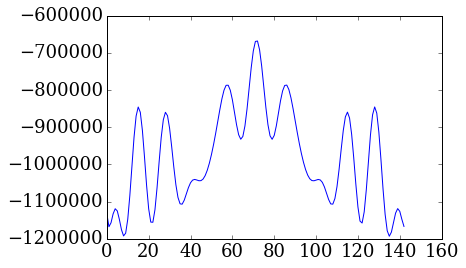

In [245]:
plt.plot(diff_cors[1][0,0])

409549.5619992445

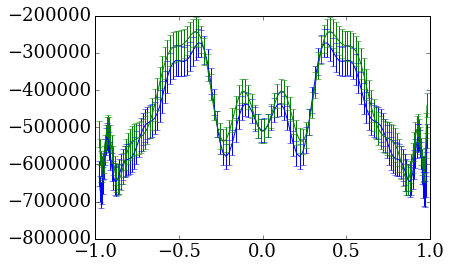

In [246]:
qidx =0
plt.errorbar(cpsi[qidx],diff_cors_legfit[0][-1,qidx],yerr=diff_errs[0][-1,qidx])
# plt.plot(cpsi[qidx],diff_cors_legfit[0][-1,qidx])

plt.errorbar(cpsi[qidx],diff_cors_legfit[0][1,qidx],yerr=diff_errs[0][-1,qidx])
# plt.plot(cpsi[qidx],diff_cors_legfit[0][1,qidx])
diff_errs[0][5,qidx].mean()
diff_cors_legfit[0][-1,qidx].max()-diff_cors_legfit[0][-1,qidx].min()

152333.06102389551

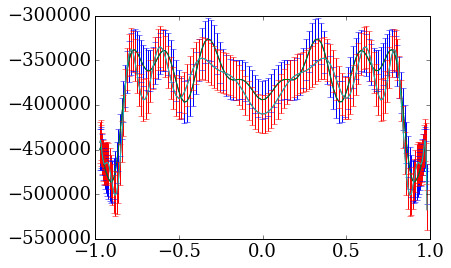

In [247]:
qidx =6
plt.errorbar(cpsi[qidx],diff_cors_legfit[1][-1,qidx],yerr=diff_errs[0][5,qidx])
plt.plot(cpsi[qidx],diff_cors_legfit[1][-1,qidx])

plt.errorbar(cpsi[qidx],diff_cors_legfit[1][0,qidx],yerr=diff_errs[0][5,qidx])
plt.plot(cpsi[qidx],diff_cors_legfit[1][0,qidx])
diff_errs[0][5,qidx].mean()
diff_cors_legfit[0][-1,qidx].max()-diff_cors_legfit[0][-1,qidx].min()

11284.081340831926

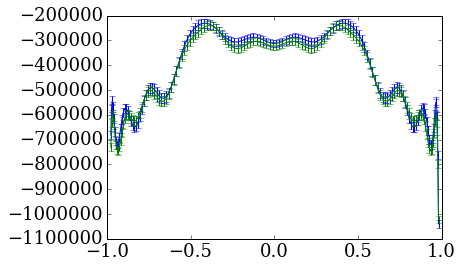

In [248]:
qidx =0
plt.errorbar(cpsi[qidx],sample_cors[0][-1,qidx],yerr=sample_errs[0][-1,qidx])
plt.errorbar(cpsi[qidx],sample_cors[0][0,qidx],yerr=sample_errs[0][-1,qidx])
# plt.errorbar(cpsi[qidx],diff_cors_legfit[0][-1,qidx],yerr=diff_errs[0][-1,qidx])

# plt.errorbar(cpsi[qidx],sample_cors[1][-1,qidx],yerr=sample_errs[0][-1,qidx])
# plt.errorbar(cpsi[qidx],sample_cors[1][0,qidx],yerr=sample_errs[0][-1,qidx])
sample_errs[3][-1,qidx].mean()

In [249]:
# ALFdiff_SNR = np.abs(diff_cors_legfit[0]/ diff_errs[0])
# GDPdiff_SNR = np.abs(diff_cors_legfit[1]/ diff_errs[1])

# ALFdiff_SNR = np.abs(diff_cors_legfit[0]).sum(-1).sum(-1)/ diff_errs[0].mean(-1).mean(-1)
# GDPdiff_SNR = np.abs(diff_cors_legfit[1]).sum(-1).sum(-1)/ diff_errs[1].mean(-1).mean(-1)

ALFdiff_SNR = (diff_cors_legfit[0]-diff_cors_legfit[0].min(-1)[:,:,None])/ diff_errs[0]
GDPdiff_SNR = (diff_cors_legfit[1]-diff_cors_legfit[1].min(-1)[:,:,None])/ diff_errs[1]

In [250]:
n_shots

[array([  27202.,   54404.,   81606.,  108808.,  136010.,  163212.,
         190414.,  217616.,  244818.,  272020.]),
 array([  65074.,  130148.,  195222.,  260296.,  325370.,  390444.,
         455518.,  520592.,  585666.,  650740.])]

[ 0.44116692 -3.63412316]
[ 0.42659637 -3.9118524 ]


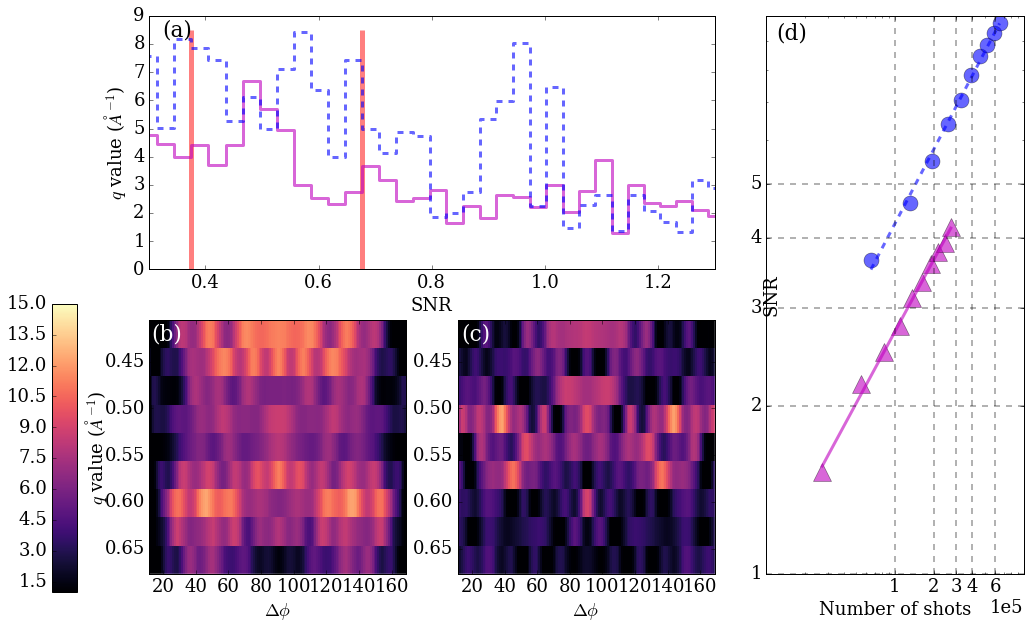

In [251]:
fig = plt.figure(figsize=[18,10])
gs = GridSpec(2,3)
#ALF SNR
ax=plt.subplot(gs[0,:2])
ax.set_title('(a)',x = 0.05, y = 0.9)
plt.step(qvalues[:],ALFdiff_SNR[-1][:].mean(-1),
        linewidth = 3, color='m', alpha = 0.6)
plt.xlim(0.3,1.3)
plt.ylabel('$q$ value ($\AA^{-1}$)')
plt.xlabel('SNR')

# GDP SNR
plt.step(qvalues[:],GDPdiff_SNR[3][:].mean(-1),
        linewidth = 3, color='b', alpha = 0.6, linestyle='--')
# plt.xlim(0.3,0.7)

plt.vlines([qvalues[3],qvalues[13]],0,8.5, 
           linewidth = 5, color='r', alpha = 0.5,
          linestyle='-')

phi = np.linspace(0,180,num_phi/2)[phi_offset:num_phi/2-phi_offset]
mm=1
mx =15

### SNR heat map, ALF
ax=plt.subplot(gs[1,1])
ax.set_title('(c)',x = 0.07, y = 0.9, color='White')
plt.imshow(ALFdiff_SNR[-1][4:13],aspect='auto',cmap='magma',
           interpolation='none',
          vmin=mm,vmax = mx,extent =[ phi[0] ,phi[-1],qvalues[13],qvalues[4]])
plt.xlabel('$\Delta \phi$')

# GDP
ax = plt.subplot(gs[1,0])
ax.set_title('(b)',x = 0.07, y = 0.9, color='White')
im=plt.imshow(GDPdiff_SNR[3][4:13],aspect='auto',cmap='magma',
              interpolation='none',
          vmin=mm,vmax = mx, extent =[ phi[0] ,phi[-1],qvalues[13],qvalues[4]])
plt.ylabel('$q$ value ($\AA^{-1}$)', labelpad = -5)
plt.xlabel('$\Delta \phi$')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.05, 0.1, 0.02, 0.4])
fig.colorbar(im, cax=cbar_ax)
cbar_ax.yaxis.set_ticks_position('left')

# fit to SNR by number of shots
ax = plt.subplot(gs[:,2])
ax.set_title('(d)',x = 0.1, y = 0.95)
ax.grid(color='k', linestyle='--', linewidth=2,alpha=0.3)
y = np.log(GDPdiff_SNR[:,4:13].mean(-1).mean(-1) )
x = np.log(n_shots[1])
plt.loglog(n_shots[1],GDPdiff_SNR[:,4:13].mean(-1).mean(-1),'bo'
          ,markersize = 15, alpha = 0.6)


coefs = polyfit(x,y,deg=1)
print coefs
plt.plot(n_shots[1],np.exp(polyval(coefs,x)), 
        linewidth = 3, color='b', alpha = 0.6, linestyle='--')

y = np.log(ALFdiff_SNR[:,4:13].mean(-1).mean(-1) )
x = np.log(n_shots[0])
plt.plot(n_shots[0],ALFdiff_SNR[:,4:13].mean(-1).mean(-1),
         'm^',markersize = 18, alpha = 0.6)
coefs = polyfit(x,y,deg=1)
print coefs
plt.plot(n_shots[0],np.exp(polyval(coefs,x) ),
        linewidth = 3, color='m', alpha = 0.6, linestyle='-')

# plt.xlim(4e4,6e5)
# plt.ylim(0.1,1.8)
plt.xticks([1e5,2e5,3e5,4e5,6e5])
plt.xlabel('Number of shots')
plt.ylabel('SNR', labelpad=-30)

ax.set_xticks([1e5,2e5,3e5,4e5,6e5])
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

ax.set_yticks([1,2,3,4,5])
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
# plt.xticks([1,2,3,4,5])

# plt.savefig('SNR_fig.png', bbox_inches='tight')

In [252]:
y = np.log((diff_errs[0])[:,4:13].mean(-1).mean(-1))
x = np.log(n_shots[0])
polyfit(x,y,deg=1)

array([ -0.49627026,  15.96170878])

In [253]:
m = (diff_cors_legfit[1]-diff_cors_legfit[1].min(-1)[:,:,None])

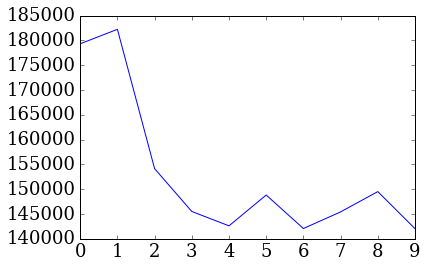

In [242]:
plt.plot(m.mean(-1)[:,2])

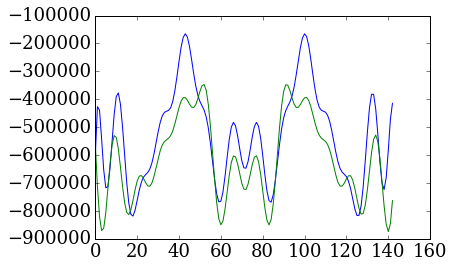

In [243]:
qidx=0
plt.plot(diff_cors_legfit[0][0,qidx])
plt.plot(diff_cors_legfit[0][-1,qidx])

In [175]:
y = np.log(ALFdiff_SNR[:,2:3].mean(-1).mean(-1) )
x = np.log(n_shots[0][:])
polyfit(x,y,deg=1)

array([ 0.45076155, -4.25481283])

In [227]:
qvalues

array([ 0.28378592,  0.3142544 ,  0.34469446,  0.3751034 ,  0.40547854,
        0.4358172 ,  0.46611672,  0.49637448,  0.52658787,  0.55675429,
        0.58687118,  0.61693601,  0.64694625,  0.67689942,  0.70679306,
        0.73662475,  0.76639207,  0.79609267,  0.8257242 ,  0.85528437,
        0.88477091,  0.91418157,  0.94351417,  0.97276654,  1.00193656,
        1.03102213,  1.06002121,  1.0889318 ,  1.11775191,  1.14647962,
        1.17511304,  1.20365032,  1.23208966,  1.26042928,  1.28866747,
        1.31680255])

In [208]:
# esimate P = 0.0035
d_jet = 50e-6 #meter
d_focus = 1e-6# meter

vol = np.pi*(d_focus/2)**2 * d_jet


num_photon_per_pulse = 1e12 

complex_weight = 1.66054e-24*40.0*1e3 *1e3 #mg, 40 kDa
water_mol_weight = 18e3/6.0221409e23 #mg 18g/mol 
concentreation = 30. #mg/ml

num_concentration = concentreation*(vol*1e6)/complex_weight
water_num = (1000-concentreation)*(vol*1e6)/water_mol_weight
print "number of proteins: %.3g"%num_concentration
print "number of water molecules: %.3g"%water_num
print num_concentration/ water_num
num_photon_per_molecue = 1 # 
num_photon_scattered = num_concentration*num_photon_per_molecue

number of proteins: 1.77e+07
number of water molecules: 1.27e+12
1.39175176313e-05


In [254]:
np.exp(-3.9)/(num_concentration*complex_weight/(water_num*water_mol_weight))/0.0036

181.8023528002802

In [212]:
(1/0.15)**2

44.44444444444445

In [225]:
((252+187.)/2)/(7+12)*2

23.105263157894736